In [1]:
from agent import CircleAgent, SensorQAgent
from gridworld import GridWorld
from collections import deque

In [23]:
grid = [
        ['-', '-', '-', '-', '-'],
        ['-', 'w', '-', 'w', '-'],
        ['-', '-', '-', '-', '-'],
        ['-', 'w', '-', 'w', '-'],
        ['-', '-', '-', '-', '-'],
    ]
env = GridWorld((0,0), (4,4), grid)
agent = CircleAgent(env,wait_time=5)

data_size = 5000
trajectory_lengths = [1,3,5,10]
window_size = 1000

In [24]:
def generate_training_data(env, agent, cutoff=10000):
    trajectory = [env.agent_location]
    time = 0
    while time < cutoff:
        action = agent.policy()
        newX = env.agent_location[0] + action[0]
        newY = env.agent_location[1] + action[1]
        trajectory.append((newX,newY))
        env.move_agent(newX, newY)
        time+=1
    return trajectory

walk = generate_training_data(env, agent, data_size)


In [25]:
import matplotlib.pyplot as plt
import numpy as np

def simple_moving_average(data, window_size):
    """
    Calculate the simple moving average.

    Parameters:
    - data: 1D NumPy array or list
    - window_size: Size of the moving average window

    Returns:
    - 1D NumPy array of the moving averages
    """
    if len(data) < window_size:
        raise ValueError("Data size must be greater than or equal to the window size.")

    # Use the 'valid' mode to ensure that output size is the same as input size
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def sum_last(data, window_size):
    '''
    Given a list of data, return the sum of the last window_size elements for each element in the list
    '''
    return [sum(data[i:i+window_size]) for i in range(len(data)-window_size)]

In [26]:
rewards = []
for traj_len in trajectory_lengths:
    q_agent = SensorQAgent(env, 0.1, 0.1,1,1) #in order, env, alpha, epsilon, w1, w2
    trajectory = deque(maxlen=traj_len)
    trajectory.append((env.agent_location, (1,0)))
    for position in walk:
        x,y = env.agent_location
        s = tuple(trajectory)
        action = q_agent.policy(s)
        dx,dy = agent.policy()
        if action[1]: #give agent knowledge of position if sensor was activated
            trajectory.append(((x+dx,y+dy), action))
        else:
            trajectory.append(((-1,-1), action))
        s_ = tuple(trajectory)
        env.move_agent(x+dx, y+dy)
        q_agent.update(s, s_)
    sma = simple_moving_average(q_agent.rewards, window_size)
    rewards.append(sma)

Text(0, 0.5, 'Sum of rewards for 1000 steps')

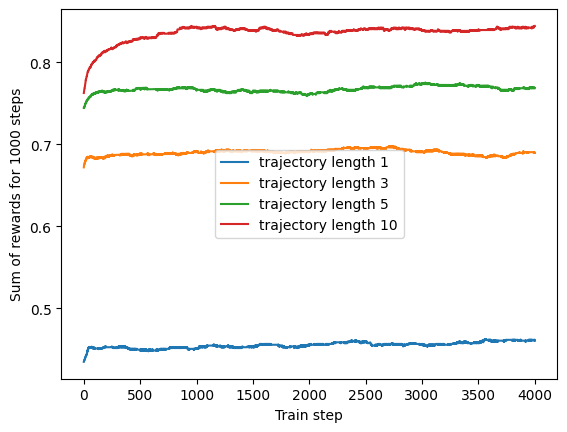

In [27]:
for i in range(len(trajectory_lengths)):
    plt.plot(rewards[i], label='trajectory length {}'.format(trajectory_lengths[i]))

plt.legend()
plt.xlabel('Train step')
plt.ylabel(f'Sum of rewards for {window_size} steps')